# Ec 143 - Problem Set 3
# Model Selection
Due by 5PM on March 24th. The GSI, Nadav Tadelis (ntadelis@berkeley.edu), will handle the logistics of problem set collection.

Working with peers on the problem set is actively encouraged, but everyone needs to turn in their own Jupyter Notebook and any other accompanying materials. All narrative responses should be placed in a markdown box below the appropriate question.

This problem set reviews the material on model selection developed in lecture.

In [1]:
# Load libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.linear_model import LinearRegression

from scipy.interpolate import griddata

The datafiles needed to complete this problem set are available on the course GitHub repository. We will use two datasets, the first is a labor force survey from Brazil (PNAD). An interesting introduction to this dataset can be found in the article D. Lam and RF Schoeni. (1993). "Effects of family background on earnings and returns to schooling: evidence from Brazil," _Journal of Political Economy_ 101 (4): 710 - 740.    

The second dataset is a consumption survey of a sample of rural households from Nicaragua. You can read more about this dataset in B. Graham and J. Powell. (2012). "Identification and estimation of average partial effects in `irregular’ correlated random coefficient panel data models," _Econometrica_ 80 (5): 2105 - 2152.

In [2]:
data = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec143/Ec143_Spring2023/Datasets/'
graphics = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec143/Ec143_Spring2023/Graphics/'

## Part 1: Analysis of Brazilian data

We will work with a PNAD subsample consisting of observations with positive monthly earnings. This allows us to define the outcome variable to be log monthly earnings, the distribution of which is well-approximated by the Gaussian distribution. We also just work with the population aged 20 to 65 years of age (prime working ages).

In [3]:
pnad96 = pd.read_csv(data + 'Brazil_1996PNAD.out', header = 0, sep='\t+', engine='python')

# Find relevant estimation subsample
sample = pnad96.loc[(pnad96['MONTHLY_EARNINGS'] > 0) & (pnad96['AgeInDays'] >= 20)  & (pnad96['AgeInDays'] < 65)]

#Display the first few rows of the dataframe
sample.describe()

,AgeInDays,YRSSCH,MONTHLY_EARNINGS,Father_NoSchool,Father_Incomplete1stPrimary,Father_Complete1stPrimary,Father_Incomplete2ndPrimary,Father_Complete2ndPrimary,Father_IncompleteSecondary,Father_CompleteSecondary,...,Mother_NoSchool,Mother_Incomplete1stPrimary,Mother_Complete1stPrimary,Mother_Incomplete2ndPrimary,Mother_Complete2ndPrimary,Mother_IncompleteSecondary,Mother_CompleteSecondary,Mother_IncompleteHigher,Mother_CompleteHigher,Mother_DontKnow
count,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,...,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000
mean,37.971992,5.747324,632.051985,0.287575,0.205027,0.138419,0.033425,0.053685,0.052159,0.038802,...,0.341052,0.188288,0.134985,0.040849,0.064370,0.031951,0.044249,0.016392,0.052991,0.084873
std,11.126182,4.231994,1105.739430,0.452636,0.403725,0.345342,0.179746,0.225397,0.222349,0.193126,...,0.474067,0.390945,0.341710,0.197943,0.245413,0.175871,0.205650,0.126978,0.224018,0.278695
min,20.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.943190,3.000000,174.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.750170,5.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.895960,8.000000,600.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,64.996570,15.000000,50000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Question 1
In a markdown box describe some basic features of our estimation sample. How many observations are available? Comment on any features of the distribution of school and/or earnings that stand out.

This next block of code shows how to use the *DecisionTreeRegressor* method in the machine learning module **sklearn**. For our initial analysis we will use just two predictors: years-of-schooling and age.

/Users/bgraham/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/bgraham/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


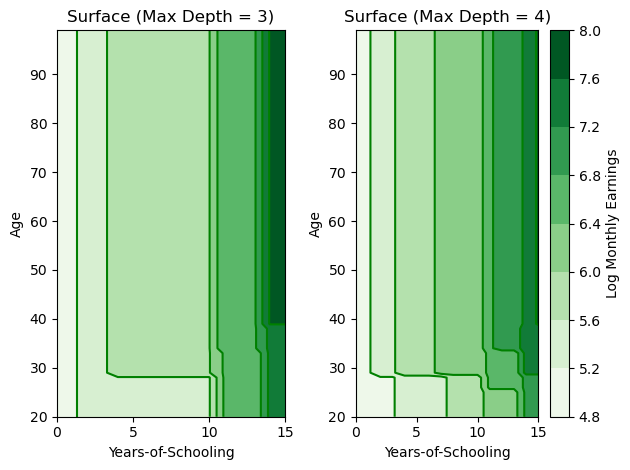

In [4]:
X = sample[['YRSSCH','AgeInDays']]
Y = np.log(sample['MONTHLY_EARNINGS'])

# Fit regression model
regr_1 = tree.DecisionTreeRegressor(max_depth=3)
regr_2 = tree.DecisionTreeRegressor(max_depth=4)
regr_1.fit(X, Y)
regr_2.fit(X, Y)

# Form interpolation grid upon which to plot estimated regression surface
Sch_i, Age_i = np.mgrid[0:16, 20:100]
Sch_i        = Sch_i.flatten('F')[:, np.newaxis]
Age_i        = Age_i.flatten('F')[:, np.newaxis]
X_i          = np.concatenate((Sch_i, Age_i ), axis=1)

y_1 = regr_1.predict(X_i)
y_2 = regr_2.predict(X_i)

Sch_i  = Sch_i.reshape((16, 80), order='F')
Age_i  = Age_i.reshape((16, 80), order='F')
y_1    = y_1.reshape((16, 80), order='F')
y_2    = y_2.reshape((16, 80), order='F')

# Create a 1 x 2 array of plots, with a contour representation of (i) the MLE regression surface
# as well as (ii) its smoothed USE counterpart.
plt.figure(1)
plt.subplot(121)
surf_1    = plt.contourf(Sch_i, Age_i, y_1, cmap='Greens')
surf_1_cl = plt.contour(surf_1,colors = 'Green')
plt.title('Surface (Max Depth = 3)')
plt.xlabel('Years-of-Schooling')
plt.ylabel('Age')

plt.subplot(122)
surf_2    = plt.contourf(Sch_i, Age_i, y_2, cmap='Greens')
surf_2_cl = plt.contour(surf_2,colors = 'Green')
cb = plt.colorbar(surf_2)
cb.set_label('Log Monthly Earnings')
plt.title('Surface (Max Depth = 4)')
plt.xlabel('Years-of-Schooling')
plt.ylabel('Age')

# Save result
plt.tight_layout()
plt.savefig(graphics + 'Fig_RegressionTreeExample.png')

### Question 2
In a separate markdown box comment on the regression tree results presented in the two figures above. What do they suggest about the relationship between schooling and earnings in Brazil? The relationship between age and earnings?

### Question 3
This next block of code prints out the fitted depth 3 regression tree. Discuss any additional features of the relationship between earnings, schooling and age that seem relevant in light of figure. Place your answer in a markdown box below the figure.

[Text(0.5, 0.875, 'Highest Grade Complete <= 10.5\nsquared_error = 1.025\nsamples = 57651\nvalue = 5.86'),
 Text(0.25, 0.625, 'Highest Grade Complete <= 3.5\nsquared_error = 0.727\nsamples = 46956\nvalue = 5.61'),
 Text(0.125, 0.375, 'Highest Grade Complete <= 1.5\nsquared_error = 0.644\nsamples = 17944\nvalue = 5.247'),
 Text(0.0625, 0.125, 'squared_error = 0.618\nsamples = 10168\nvalue = 5.092'),
 Text(0.1875, 0.125, 'squared_error = 0.607\nsamples = 7776\nvalue = 5.448'),
 Text(0.375, 0.375, 'Age <= 28.957\nsquared_error = 0.645\nsamples = 29012\nvalue = 5.835'),
 Text(0.3125, 0.125, 'squared_error = 0.484\nsamples = 9446\nvalue = 5.554'),
 Text(0.4375, 0.125, 'squared_error = 0.667\nsamples = 19566\nvalue = 5.971'),
 Text(0.75, 0.625, 'Highest Grade Complete <= 13.5\nsquared_error = 0.864\nsamples = 10695\nvalue = 6.954'),
 Text(0.625, 0.375, 'Age <= 33.666\nsquared_error = 0.672\nsamples = 6810\nvalue = 6.636'),
 Text(0.5625, 0.125, 'squared_error = 0.567\nsamples = 2558\nvalue = 

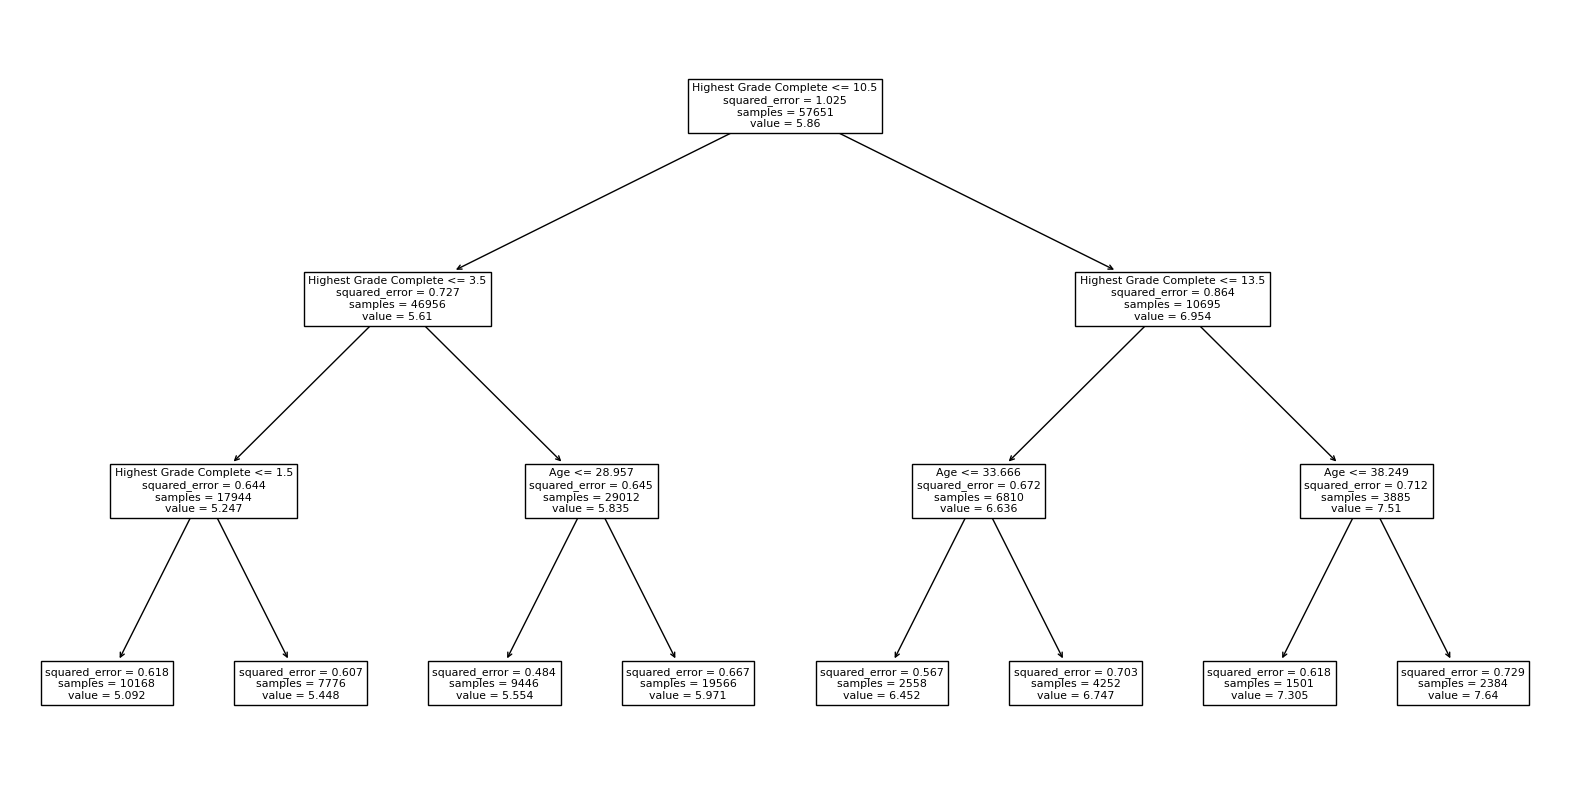

In [5]:
plt.figure(figsize=(20, 10))
tree.plot_tree(regr_1, feature_names = ['Highest Grade Complete', 'Age'])

### Question 4
The next block of code define a function which returns Ye's (1998) unbiased risk estimate for regression trees. Add a decription to this function. This description should define each of the function's six parameters as well as its three outputs. Add comments to the function which describe the operations made by the different blocks of code within it.

In [6]:
def tree_SURE(X, Y, sigma2, J, h, S):
    
    """Description of function"""
    
    [N, _] = np.shape(X)
    
    YE_matrix   = np.zeros((N,S))
    Ds_matrix   = np.zeros((N,S))
    DmDy_vector = np.zeros((N,))
    
    regr_J  = tree.DecisionTreeRegressor(max_depth=J)
    regr_J.fit(X, Y)
    m_hat_J = regr_J.predict(X)
    SSR     = np.sum((Y - m_hat_J)**2)
    
    for s in range(0,S):
        D_s     = np.random.normal(0, h, size=(N,))
        regr_J.fit(X, Y + D_s)
        m_hat_s = regr_J.predict(X)
        YE_matrix[:,s] = m_hat_s
        Ds_matrix[:,s] = D_s
    
    for i in range(0,N):
        DmDy_i_reg     = LinearRegression(fit_intercept=True).fit(Ds_matrix[i,:,np.newaxis], YE_matrix[i,:])
        DmDy_vector[i] = DmDy_i_reg.coef_[0]

    df_hat  = np.sum(DmDy_vector) 
    
    if not sigma2:
        sigma2 = (1/(N-df_hat))*SSR
    
    sure       = -N*sigma2 + SSR + 2*sigma2*df_hat 
    
    return [sure, sigma2, df_hat]

### Question 5
This next block of code uses **treeSURE** to select the maximum depth of our regression tree model for log earnings as a function of schooling and age. Please add comments to the code; explaining the role of each block of code.

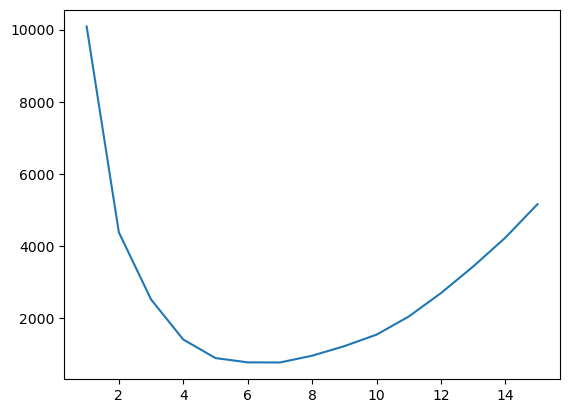

In [7]:
L           = 15
h_sv        = 0.6*np.std(Y)
S           = 100

[sure, s2_hat, df_hat] = tree_SURE(X, Y, [], L, h_sv, S)
h           = 0.6*s2_hat**(1/2)

J_values   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
risk_table = np.zeros((len(J_values),2))

                      
m = 0                      
for J in J_values:
    [sure, _, _] = tree_SURE(X, Y, s2_hat, J, h, S)
    risk_table[m,:] = [J, sure]
    m += 1                  

fig = plt.figure()
ax = plt.axes()
ax.plot(risk_table[:,0], risk_table[:,1])

### Question 6
Fit the regression tree that minimizes SURE. Construct a contour plot of the resulting regression surface (you may adapt the code given above). Discuss your plot and what it suggests about the relationship between earnings and schooling and age in Brazil.

## Part 2: Analysis of Nicarguan data (extra credit, 5 points)
This part of the problem set will use calorie consumption data from a sample of rural households in Nicargua. We are interested in the relationship between total household outlay and calorie consumption. Understanding the nature of food demand in low income settings has important implications for understanding the prevalence of hunger and for food policy. The article by Shankar Subramanian and Angus Deaton. (1996). "The demand for food and calories," _Journal of Political Economy_ 104 (1): 133 - 162 provides a nice example of economics research in this area.

The dataset includes several years of data. We will work with X0 and Y0, which correspond to household outlay (in Cordobas) per adult equivalent and calorie consumption per adult equivalent respectively in the base year of of the survey (2000). 

In [8]:
calories = pd.read_csv(data + 'RPS_calorie_data.out', header = 0)
calories['constant'] = 1
calories[['constant','X0','Y0']][0:5]

,constant,X0,Y0
0,1,8.819086,7.963177
1,1,6.889811,6.484601
2,1,6.650684,6.876681
3,1,6.909742,6.754492
4,1,8.034308,7.162158


This first block of code fits a simple linear regression model to the calorie data.

Coefficients: 
 [1.87831534 0.68778462]


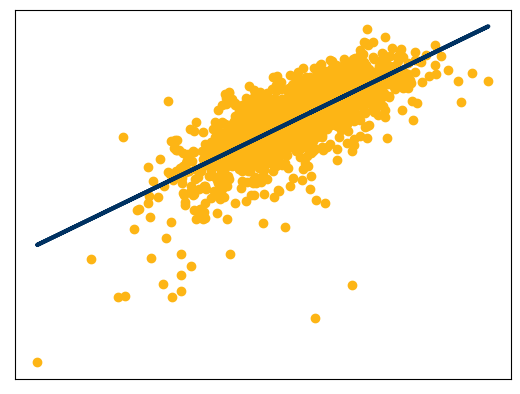

In [9]:
from sklearn import linear_model

W = calories[['constant', 'X0']]
Y = calories['Y0']

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Fir the calorie demand model
regr.fit(W, Y)

# Compute fitted values
calories_pred = regr.predict(W)

# Print out the estimated regression coefficients
print("Coefficients: \n", regr.coef_)

# Plot fitted regression model
plt.scatter(calories['X0'], calories['Y0'], color="#FDB515")
plt.plot(calories['X0'], calories_pred, color="#003262", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### Question 7
For this final questions, which is a long one, you will consider alternative series approximations of the the regression function for calories given total outlay. In the example above we considered a linear model. What about a model which is quadratic in outlay? Cubic? Quartic?   

Write a function that computes the series regression of Y onto $1, X, X^2, \ldots, X^{J-1}$ by least squares. Write a second function that compute Mallows $C_J$ risk estimate. Using these functions first compute a "big" model in order to construct a good estimate of $\sigma^2$, the variance of the regression error. With this estimate in hand compute Mallows $C_J$ risk estimate for $J=1,2,3,\ldots$.   

Fit the model which minimizes estimated risk. Produce the corresponding scatter plot with the fitted curve overlayed. Discuss your results.